number 1 x 2.7952684806173362 y 1.5313907571766996
number 2 x 2.6088322474568466 y 1.4717424777425774
number 3 x 2.443945311406181 y 1.4198510448195987
number 4 x 2.297132373760091 y 1.3742414225057336
number 5 x 2.1659397900696415 y 1.3339340559960395
number 6 x 2.048448953236742 y 1.2981966123883653
number 7 x 1.9430777881573111 y 1.2664444997998268
number 8 x 1.8484821361567982 y 1.2381927344583954
number 9 x 1.7634992884440976 y 1.2130293150416076
number 10 x 1.6871119730548927 y 1.1905989083117634
number 11 x 1.6184234023044972 y 1.1705920075164133
number 12 x 1.5566388546644776 y 1.1527372392481703
number 13 x 1.5010514153751318 y 1.1367956061479734
number 14 x 1.4510305363755984 y 1.1225559895990271
number 15 x 1.406012612062035 y 1.109831514907853
number 16 x 1.3654930615221208 y 1.0984565345100359
number 17 x 1.3290195778909764 y 1.0882840729861258
number 18 x 1.2961863083976133 y 1.0791836305312357
number 19 x 1.2666287937253866 y 1.0710392741390447
number 20 x 1.240019538128

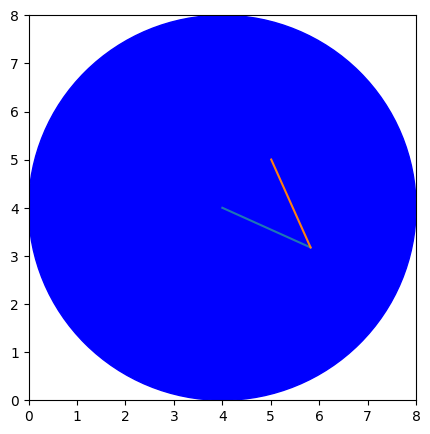

In [2]:
import numpy as np
import math
from sympy.geometry import *
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import matplotlib.animation as animation
def now_hand_position(L,theta):#順運動学
    x = L * math.cos(theta)
    y = L * math.sin(theta)
    return x,y

    
def  Jacobian(L1,theta1, L2, theta2):#ヤコビアン2×2
    """
    -----------------------説明-------------------------
    J = [[∂x/∂θ1, ∂x/∂θ2],
         [∂y/∂θ1, ∂y/∂θ2]]
    J = [[xをθ1で偏微分, xをθ2で偏微分],     
         [yをθ1で偏微分, yをθ2で偏微分]]
    -----------------------------------------------------
    """
    J = np.array([[-L1*math.sin(theta1) - L2*math.sin(theta1+theta2), -L2*math.sin(theta1+theta2)],
                  [ L1*math.cos(theta1) + L2*math.cos(theta1+theta2),  L2*math.cos(theta1+theta2)]])
    return J

def trans_matrix(mat):#転置行列2×2
    """
    -----------------------説明-------------------------
    行列はnumpyの記述方法で記述する
    行列A       = [[a, b],
                   [c, d]]　のとき
    転置行列A.T = [[a, c],
                   [b, d]]
    -----------------------------------------------------
    """
    mat_minus =  np.array([[mat[0,0], mat[1,0]],
                           [mat[0,1], mat[1,1]]])
    return mat_minus

def inverse_matrix(mat):#逆行列2×2（以下の公式が使えるのは2×2のときのみ，3×3以上は掃き出し法により算出）
    """
    -----------------------説明-------------------------
    A=  [[a, b],
         [c, d]] の逆行列は，
    A^−1   = 1/ad−bc  * [[d, −b]
                         [-c, a]] 
    -----------------------------------------------------
    """
    inverse_mat = 1/(mat[0,0]*mat[1,1] - mat[0,1]*mat[1,0]) * np.array([[mat[1,1], -mat[0,1]],
                                                                        [-mat[1,0], mat[0,0]]])
    return inverse_mat                                                                      

def pseudo_inverse_matrix(mat, trans_mat):#擬似逆行列（正方行列以外の逆行列を用いるときに使用．今回は，2×2の正方行列であるため，この関数は使用しなくても可）
    """
    -----------------------説明-------------------------
    擬似逆行列A+ =(A.T * A)^-1 * A.T
    記号の意味-----------
    A.T ：転置行列
    A^-1：逆行列
    *   ：内積
    ---------------------
    -----------------------------------------------------
    """
    mat_p_inverse = np.dot(inverse_matrix(np.dot(trans_mat,mat)),trans_mat)
    return mat_p_inverse

def Inverse_kinematics(x, y, goal_x, goal_y, L1, L2, theta1, theta2):
    j = 0
    for i in range(100):
        J = Jacobian(L1, theta1, L2, theta2)#ヤコビアン
        J_trans = trans_matrix(J)#ヤコビアンの転置
        J_inverse = inverse_matrix(J)#ヤコビアンの逆行列
        J_p_inverse = pseudo_inverse_matrix(J, J_trans)#ヤコビアンの擬似逆行列（今回は正方行列なのでJ_inverseと同じ値になる）
        """
        if  (J_p_inverse == -np.inf).any() or (J_p_inverse == np.inf).any() :
            theta1 += 0.1
            theta2 += 0.1
            continue
        """
        Q = np.array([[theta1],
                      [theta2]])#各角度をリストQに格納
        dx = goal_x - x #x方向の目標距離と現在距離との差分（差が大きいと動かす角度も増加）
        dy = goal_y - y #y方向の目標距離と現在距離との差分（差が大きいと動かす角度も増加）
        delta_Q = np.dot(J_inverse, np.array([[dx*0.1],
                                              [dy*0.1]]))#下記のニュートン法の式のJ^-1*f_nに当たる（はず）
        Q_new = Q + delta_Q#新しい角度を求める（ニュートン法に基づく）ニュートン法：x_n+1 = x_n - J^-1*f_n
        theta1 = Q_new[0,0]; theta2 = Q_new[1,0]
        x1, y1 = now_hand_position(L1, theta1)#リンク〜関節1（リンク2の根本）までのx,y
        x2, y2 = now_hand_position(L2, theta1+theta2)#関節1（リンク2の根本）から手先までのx,y
        x = x1+x2 #原点（リンク1の根本）〜手先までのx
        y = y1+y2 #原点（リンク1の根本）〜手先までのy
        j += 1 #for文を繰り返したかをカウント（デバック用）
        print("number",j,"x",x,"y", y)
        #各関節が2π(360度)を超えたら0.0radに戻る
        if 2*math.pi < theta1:
            theta1 = 0.0
        if 2*math.pi < theta2:
            theta2 = 0.0
        #手先が目標座標あたりにきたらfor文から抜ける
        if (goal_x-0.01< x <goal_x+0.01) and (goal_y-0.01 < y <goal_y+0.01):
            break
    #繰り返し距離が一定以上なら，計算ができていないとしてprint文で出力
    if 90 < j:
        print("位置を計算できませんでした（特異点，もしくは実現不可能な座標の可能性があります）")
    print("final_x", x ,"final_y", y)#最終的な手先の座標を出力
    print("number of loop",j)#最終的なループの回数を出力
    return theta1, theta2
        



if __name__ == '__main__':
    ################行列式デバック用#############
    """
    mat = np.array([[3.0, 2.0],
                    [1.0, 4.0]])#行列
    trans_mat = trans_matrix(mat)#転置行列
    print("trans_mat", trans_mat)
    inverse_mat = inverse_matrix(mat)#逆行列
    print("inverse_mat", inverse_mat)
    mat_p_inverse = pseudo_inverse_matrix(mat, trans_mat)#擬似逆行列
    print("mat_p_inverse", mat_p_inverse)
    """
    ################################################

    #必要な変数（リンクの長さ，関節角度，目標座標など）を用意##
    L1 = 2.0    
    deg1 = 20
    rad1 = deg1*math.pi/180
    L2 = 2.0
    deg2 = 20
    rad2 = deg2*math.pi/180
    x1, y1 = now_hand_position(L1, rad1)
    x2, y2 = now_hand_position(L2,rad1+rad2)
    x = x1+x2
    y = x1+x2
    goal_x = float(input("目標座標xを入力（アームの範囲は半径4.0の円）"))
    goal_y = float(input("目標座標yを入力（アームの範囲は半径4.0の円）"))
    
    ###########################################################
    
    #逆運動学（最終的な各関節の角度が返り値）
    final_theta1, final_theta2 = Inverse_kinematics(x, y, goal_x, goal_y, L1, L2, rad1, rad2)
    #rad→degに変換（確認)
    deg1, deg2 = 180*final_theta1/math.pi, 180*final_theta2/math.pi
    print("final_theta1,final_theta2",deg1, deg2)

    #####以下グラフ表示に関する記述########
    x0, y0 = L1+L2, L1+L2
    x1, y1 = now_hand_position(L1, final_theta1)
    x0_x1, y0_y1 = x0    + x1, y0    + y1
    x2, y2 = now_hand_position(L2, final_theta1+final_theta2)
    x0_x2, x0_y2 = x0_x1 + x2, y0_y1 + y2

    fig = plt.figure(figsize=(5,5))
    ax1 = fig.add_subplot(1, 1, 1)
    #Segment(Point(x0,y0), Point(x1,y1)):2つの点を結ぶ線分 
    s0 = Segment(Point(x0   , y0)   ,Point(x0_x1, y0_y1))
    s1 = Segment(Point(x0_x1, y0_y1),Point(x0_x2, x0_y2))
    segments = [s0, s1]
    #アームの駆動範囲の円（真円）
    circle1 = pat.Circle(xy = (x0, y0), radius= L1+L2, color="blue")
    ax1.add_patch(circle1)
    # グラフ描画
    for i,s in enumerate(segments) :
        plt.plot([s.p1.x, s.p2.x], [s.p1.y, s.p2.y])
    plt.xlim(0,(L1+L2)*2)
    plt.ylim(0,(L1+L2)*2)
    plt.show()



In [ ]:
import numpy as np
import math
from sympy.geometry import *
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import matplotlib.animation as animation
def forward_kinematics_2d(L,theta):#順運動学
    """
    2次元平面ロボットにおける、回転ロボットの順運動学を解く
    
    Parameters
    -----------
    L : float
        リンクの長さ
    theta: float
        リンクの回転角度（degree）

    Returns
    ------------
    x : float
        リンク先端のx座標
    y : float
        リンク先端のy座標
    """
    
    x = L * math.cos(np.radians(theta))
    y = L * math.sin(np.radians(theta))
    return x,y

    
def  Jacobian(L1,theta1, L2, theta2):#ヤコビアン2×2
    """
    2次元平面、2軸の回転関節を持つロボットのヤコビアンを求める
    J = [[∂x/∂θ1, ∂x/∂θ2],
         [∂y/∂θ1, ∂y/∂θ2]]
    J = [[xをθ1で偏微分, xをθ2で偏微分],     
         [yをθ1で偏微分, yをθ2で偏微分]]

    Parameters
    -----------
    L1 : float
        リンク1の長さ
    theta1: float
        リンク2の回転角度（degree）
    L2 : float
        リンク2の長さ
    theta2: float
        リンク2の回転角度（degree）

    Returns
    ------------
    J : numpy array
        ヤコビアン
    """
    J = np.array([[-L1*math.sin(theta1) - L2*math.sin(theta1+theta2), -L2*math.sin(theta1+theta2)],
                  [ L1*math.cos(theta1) + L2*math.cos(theta1+theta2),  L2*math.cos(theta1+theta2)]])
    return J

def trans_matrix(mat):#転置行列2×2
    """
    -----------------------説明-------------------------
    行列はnumpyの記述方法で記述する
    行列A       = [[a, b],
                   [c, d]]　のとき
    転置行列A.T = [[a, c],
                   [b, d]]
    -----------------------------------------------------
    """
    mat_minus =  np.array([[mat[0,0], mat[1,0]],
                           [mat[0,1], mat[1,1]]])
    return mat_minus

def inverse_matrix(mat):#逆行列2×2（以下の公式が使えるのは2×2のときのみ，3×3以上は掃き出し法により算出）
    """
    -----------------------説明-------------------------
    A=  [[a, b],
         [c, d]] の逆行列は，
    A^−1   = 1/ad−bc  * [[d, −b]
                         [-c, a]] 
    -----------------------------------------------------
    """
    inverse_mat = 1/(mat[0,0]*mat[1,1] - mat[0,1]*mat[1,0]) * np.array([[mat[1,1], -mat[0,1]],
                                                                        [-mat[1,0], mat[0,0]]])
    return inverse_mat                                                                      

def pseudo_inverse_matrix(mat, trans_mat):#擬似逆行列（正方行列以外の逆行列を用いるときに使用．今回は，2×2の正方行列であるため，この関数は使用しなくても可）
    """
    -----------------------説明-------------------------
    擬似逆行列A+ =(A.T * A)^-1 * A.T
    記号の意味-----------
    A.T ：転置行列
    A^-1：逆行列
    *   ：内積
    ---------------------
    -----------------------------------------------------
    """
    mat_p_inverse = np.dot(inverse_matrix(np.dot(trans_mat,mat)),trans_mat)
    return mat_p_inverse

def Inverse_kinematics(x, y, goal_x, goal_y, L1, L2, theta1, theta2):
    j = 0
    for i in range(100):
        J = Jacobian(L1, theta1, L2, theta2)#ヤコビアン
        J_trans = trans_matrix(J)#ヤコビアンの転置
        J_inverse = inverse_matrix(J)#ヤコビアンの逆行列
        J_p_inverse = pseudo_inverse_matrix(J, J_trans)#ヤコビアンの擬似逆行列（今回は正方行列なのでJ_inverseと同じ値になる）
        """
        if  (J_p_inverse == -np.inf).any() or (J_p_inverse == np.inf).any() :
            theta1 += 0.1
            theta2 += 0.1
            continue
        """
        Q = np.array([[theta1],
                      [theta2]])#各角度をリストQに格納
        dx = goal_x - x #x方向の目標距離と現在距離との差分（差が大きいと動かす角度も増加）
        dy = goal_y - y #y方向の目標距離と現在距離との差分（差が大きいと動かす角度も増加）
        delta_Q = np.dot(J_inverse, np.array([[dx*0.1],
                                              [dy*0.1]]))#下記のニュートン法の式のJ^-1*f_nに当たる（はず）
        Q_new = Q + delta_Q#新しい角度を求める（ニュートン法に基づく）ニュートン法：x_n+1 = x_n - J^-1*f_n
        theta1 = Q_new[0,0]; theta2 = Q_new[1,0]
        x1, y1 = now_hand_position(L1, theta1)#リンク〜関節1（リンク2の根本）までのx,y
        x2, y2 = now_hand_position(L2, theta1+theta2)#関節1（リンク2の根本）から手先までのx,y
        x = x1+x2 #原点（リンク1の根本）〜手先までのx
        y = y1+y2 #原点（リンク1の根本）〜手先までのy
        j += 1 #for文を繰り返したかをカウント（デバック用）
        print("number",j,"x",x,"y", y)
        #各関節が2π(360度)を超えたら0.0radに戻る
        if 2*math.pi < theta1:
            theta1 = 0.0
        if 2*math.pi < theta2:
            theta2 = 0.0
        #手先が目標座標あたりにきたらfor文から抜ける
        if (goal_x-0.01< x <goal_x+0.01) and (goal_y-0.01 < y <goal_y+0.01):
            break
    #繰り返し距離が一定以上なら，計算ができていないとしてprint文で出力
    if 90 < j:
        print("位置を計算できませんでした（特異点，もしくは実現不可能な座標の可能性があります）")
    print("final_x", x ,"final_y", y)#最終的な手先の座標を出力
    print("number of loop",j)#最終的なループの回数を出力
    return theta1, theta2
        



if __name__ == '__main__':
    ################行列式デバック用#############
    """
    mat = np.array([[3.0, 2.0],
                    [1.0, 4.0]])#行列
    trans_mat = trans_matrix(mat)#転置行列
    print("trans_mat", trans_mat)
    inverse_mat = inverse_matrix(mat)#逆行列
    print("inverse_mat", inverse_mat)
    mat_p_inverse = pseudo_inverse_matrix(mat, trans_mat)#擬似逆行列
    print("mat_p_inverse", mat_p_inverse)
    """
    ################################################

    #必要な変数（リンクの長さ，関節角度，目標座標など）を用意##
    L1 = 2.0    
    deg1 = 20
    rad1 = deg1*math.pi/180
    L2 = 2.0
    deg2 = 20
    rad2 = deg2*math.pi/180
    x1, y1 = now_hand_position(L1, rad1)
    x2, y2 = now_hand_position(L2,rad1+rad2)
    x = x1+x2
    y = x1+x2
    goal_x = float(input("目標座標xを入力（アームの範囲は半径4.0の円）"))
    goal_y = float(input("目標座標yを入力（アームの範囲は半径4.0の円）"))
    
    ###########################################################
    
    #逆運動学（最終的な各関節の角度が返り値）
    final_theta1, final_theta2 = Inverse_kinematics(x, y, goal_x, goal_y, L1, L2, rad1, rad2)
    #rad→degに変換（確認)
    deg1, deg2 = 180*final_theta1/math.pi, 180*final_theta2/math.pi
    print("final_theta1,final_theta2",deg1, deg2)

    #####以下グラフ表示に関する記述########
    x0, y0 = L1+L2, L1+L2
    x1, y1 = now_hand_position(L1, final_theta1)
    x0_x1, y0_y1 = x0    + x1, y0    + y1
    x2, y2 = now_hand_position(L2, final_theta1+final_theta2)
    x0_x2, x0_y2 = x0_x1 + x2, y0_y1 + y2

    fig = plt.figure(figsize=(5,5))
    ax1 = fig.add_subplot(1, 1, 1)
    #Segment(Point(x0,y0), Point(x1,y1)):2つの点を結ぶ線分 
    s0 = Segment(Point(x0   , y0)   ,Point(x0_x1, y0_y1))
    s1 = Segment(Point(x0_x1, y0_y1),Point(x0_x2, x0_y2))
    segments = [s0, s1]
    #アームの駆動範囲の円（真円）
    circle1 = pat.Circle(xy = (x0, y0), radius= L1+L2, color="blue")
    ax1.add_patch(circle1)
    # グラフ描画
    for i,s in enumerate(segments) :
        plt.plot([s.p1.x, s.p2.x], [s.p1.y, s.p2.y])
    plt.xlim(0,(L1+L2)*2)
    plt.ylim(0,(L1+L2)*2)
    plt.show()

